# D22124454 - Deep Learning Assignment - Part 2
# Transfer learning task:

#### System specifics:
OS: Windows 11

RAM: 32 GB

GPU: RTX 3070

IDE: Models initially trained and evaluated on local - Jupyter IDE

#### Task overview:
This task is about using the models trained from Part 1 to augment the training of the models in Part 2 on a different, but similar dataset (both datasets are about news articles). Here, we tune a couple layers in previously trained models and use it for prediction in a different dataset.

#### Note:
#### In this notebook, we have the training and validation comparisons, along with a graph for evaluation. The best performing models will be evaluated again in the demo notebooks. The training was done in local with 20 epochs, so it might not give similar results with less epochs in collab.This might affect model performance.

#### FAQ:
- If some of the plotly graphs are not rendering, run the code above the imports. For local running, it is "iframe". For colab running, it is "colab".
- Please enable GPU before running

### Imports:

In [ ]:
#IF PLOTLY GRAPHS DO NOT RENDER. SET TO COLAB WHEN RUN IN COLAB AND IFRAME FOR LOCAL (iframe)
#import plotly.io as pio
#pio.renderers.default = 'colab'

In [3]:
import pandas as pd
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk import word_tokenize
from nltk.corpus import stopwords
import string

from sklearn.model_selection import train_test_split

import tensorflow as tf
import numpy as np

In [4]:
import tensorflow_hub as hub

import numpy as np
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Embedding, Conv1D, GlobalMaxPooling1D, GlobalAveragePooling1D, LSTM, SimpleRNN, MaxPooling1D, Conv1D, TimeDistributed, AveragePooling1D
from tensorflow.keras.datasets import imdb
import tensorflow as tf

import plotly.express as px
import matplotlib.pyplot as plt

In [5]:
from sklearn.preprocessing import OneHotEncoder
import re

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, accuracy_score

In [6]:
from keras.preprocessing.text import Tokenizer

In [7]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [8]:
# credentials to get the data file
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

### Read the data from the csv file

In [9]:
# https://drive.google.com/file/d/1sD2qf_JAOXKPQ6VuxpprYGfAZr1dAWmY/view?usp=sharing
bbcCsv = drive.CreateFile({'id':'1sD2qf_JAOXKPQ6VuxpprYGfAZr1dAWmY'})
bbcCsv.GetContentFile('bbc-text.csv')

In [10]:
raw_data = pd.read_csv("bbc-text.csv", delimiter =",", index_col=False)
display(raw_data)

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...
...,...,...
2220,business,cars pull down us retail figures us retail sal...
2221,politics,kilroy unveils immigration policy ex-chatshow ...
2222,entertainment,rem announce new glasgow concert us band rem h...
2223,politics,how political squabbles snowball it s become c...


### Study the categories

Here, we study the categories like in the previous part just to verify if there is anything that can be cleaned or filtered.

In [11]:
topic_list_all = np.array(raw_data["category"])
unique_top, top_counts = np.unique(topic_list_all, return_counts=True)

In [12]:
fig = px.bar(
    raw_data, x=unique_top, y=top_counts,
    title = "Fig: Topics in raw data",
    labels={'x' : 'Topics', 'y': 'No. of occurance'}
)

fig.update_layout(barmode='stack', xaxis={'categoryorder':'total descending'})

fig.show()

From the above, we can see that there are only 5 categories. We can take them as is.

### Preprocessing the data

In [ ]:
# Removing the non-alphanumeric characters (like a-hat)
proc_dataset = raw_data.copy()
proc_dataset['text'] = proc_dataset['text'].apply(lambda a: str(a).encode('ascii','ignore'))
proc_dataset['text'] = proc_dataset['text'].apply(lambda a: a.decode('ascii','ignore'))

In [ ]:
# Removing punction because we are not generating sentences. So they shouldn't be important
proc_dataset["NoPunct"] = proc_dataset['text'].str.replace('[^\w\s]','')

### Splitting the dataset

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(proc_dataset['NoPunct'], proc_dataset['category'], random_state=10, test_size=0.20)

#Print out the unique values in y to check if everything is distributed properly
print(len(y_train.unique()))
print(len(y_test.unique()))

5
5


In [ ]:
oh = OneHotEncoder()
y_train_le = pd.get_dummies(y_train)
y_test_le = pd.get_dummies(y_test)

display(y_train_le)

,business,entertainment,politics,sport,tech
24,False,False,False,False,True
317,False,True,False,False,False
949,False,False,False,True,False
31,False,False,False,False,True
746,True,False,False,False,False
...,...,...,...,...,...
2009,False,False,False,True,False
1180,True,False,False,False,False
1344,False,False,False,False,True
527,True,False,False,False,False


### Transfer learning - Model 1 : CNN pretrained

In [ ]:
tf_model_1 = tf.keras.models.load_model('saved_model/model6save')
tf_model_1.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding_4 (Embedding)     (None, None, 16)          1120000   
                                                                 
 conv1d_1 (Conv1D)           (None, None, 80)          3920      
                                                                 
 global_average_pooling1d_1   (None, 80)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_21 (Dense)            (None, 400)               32400     
                                                                 
 dense_22 (Dense)            (None, 400)              

In [ ]:
print(trial_load.layers[0])
# Freezing everything except the embedding layer last layer that outputs the labels. 
# We will be training this to output 5 categories instead
tf_model_1.layers[0].trainable = True
tf_model_1.layers[1].trainable = True
tf_model_1.layers[2].trainable = False
tf_model_1.layers[3].trainable = False
tf_model_1.layers[4].trainable = False
tf_model_1.layers[5].trainable = False

tf_model_1.layers[6].trainable = True

In [ ]:
# Adding a softmax layer to get 5 possible outputs at the end
tf_model_1.add(tf.keras.layers.Dense(5, activation='softmax', name='new_dense_3'))

In [ ]:
tf_model_1.compile(optimizer='adam',
              loss='categorical_crossentropy',
             metrics=['accuracy'])

tf_model_1_hist = tf_model_1.fit(X_train, y_train_le,
          batch_size=32,
          epochs=20,
         validation_split=0.05)

Epoch 1/20
53/53 [==============================] - 2s 21ms/step - loss: 1.5533 - accuracy: 0.2028 - val_loss: 1.4621 - val_accuracy: 0.3483
Epoch 2/20
53/53 [==============================] - 1s 19ms/step - loss: 1.3987 - accuracy: 0.4666 - val_loss: 1.3544 - val_accuracy: 0.5056
Epoch 3/20
53/53 [==============================] - 1s 19ms/step - loss: 1.2903 - accuracy: 0.6393 - val_loss: 1.2788 - val_accuracy: 0.7528
Epoch 4/20
53/53 [==============================] - 1s 20ms/step - loss: 1.1948 - accuracy: 0.8273 - val_loss: 1.1652 - val_accuracy: 0.7978
Epoch 5/20
53/53 [==============================] - 1s 20ms/step - loss: 1.0765 - accuracy: 0.8711 - val_loss: 1.0613 - val_accuracy: 0.8876
Epoch 6/20
53/53 [==============================] - 1s 21ms/step - loss: 0.9826 - accuracy: 0.9213 - val_loss: 0.9795 - val_accuracy: 0.9101
Epoch 7/20
53/53 [==============================] - 1s 19ms/step - loss: 0.8998 - accuracy: 0.9503 - val_loss: 0.9184 - val_accuracy: 0.9213
Epoch 8/20
53

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


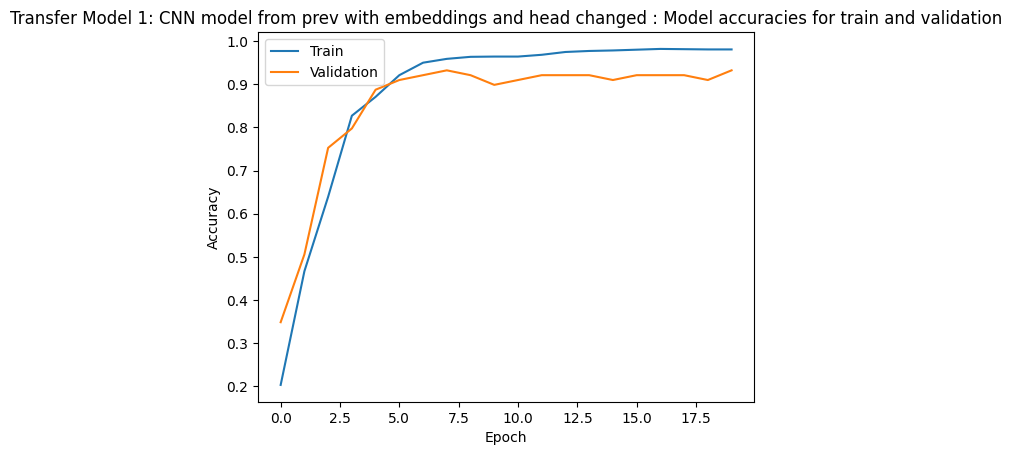

In [ ]:
print(tf_model_1_hist.history.keys())

plt.clf()
plt.plot(tf_model_1_hist.history['accuracy'])
plt.plot(tf_model_1_hist.history['val_accuracy'])
plt.title('Transfer Model 1: CNN model from prev with embeddings and head changed : Model accuracies for train and validation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Transfer learning - Model 2 : CNN + LSTM pretrained

In [ ]:
tf_model_2 = tf.keras.models.load_model('saved_model/model7save')
tf_model_2.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding_6 (Embedding)     (None, None, 16)          1120000   
                                                                 
 conv1d_5 (Conv1D)           (None, None, 80)          25680     
                                                                 
 average_pooling1d_2 (Averag  (None, None, 80)         0         
 ePooling1D)                                                     
                                                                 
 conv1d_6 (Conv1D)           (None, None, 80)          64080     
                                                                 
 average_pooling1d_3 (Averag  (None, None, 80)        

In [ ]:
#14 total

#Leaving the last, embedding layers as is like the previous one
tf_model_2.layers[0].trainable = True
tf_model_2.layers[1].trainable = True
tf_model_2.layers[2].trainable = False
tf_model_2.layers[3].trainable = False
tf_model_2.layers[4].trainable = False
tf_model_2.layers[5].trainable = False
tf_model_2.layers[6].trainable = False
tf_model_2.layers[7].trainable = False
tf_model_2.layers[8].trainable = False
tf_model_2.layers[9].trainable = False
tf_model_2.layers[10].trainable = False
tf_model_2.layers[11].trainable = False
tf_model_2.layers[12].trainable = False


tf_model_2.layers[13].trainable = True
tf_model_2.add(tf.keras.layers.Dense(5, activation='softmax', name='new_dense_6'))

In [ ]:
tf_model_2.compile(optimizer='adam',
              loss='categorical_crossentropy',
             metrics=['accuracy'])

tf_model_2_hist = tf_model_2.fit(X_train, y_train_le,
          batch_size=32,
          epochs=20,
         validation_split=0.05)

Epoch 1/20
53/53 [==============================] - 9s 123ms/step - loss: 1.6580 - accuracy: 0.1798 - val_loss: 1.6640 - val_accuracy: 0.1573
Epoch 2/20
53/53 [==============================] - 6s 106ms/step - loss: 1.6150 - accuracy: 0.1987 - val_loss: 1.6383 - val_accuracy: 0.1573
Epoch 3/20
53/53 [==============================] - 6s 104ms/step - loss: 1.5657 - accuracy: 0.3105 - val_loss: 1.5862 - val_accuracy: 0.2809
Epoch 4/20
53/53 [==============================] - 5s 104ms/step - loss: 1.4971 - accuracy: 0.4281 - val_loss: 1.5468 - val_accuracy: 0.3258
Epoch 5/20
53/53 [==============================] - 6s 104ms/step - loss: 1.4316 - accuracy: 0.4873 - val_loss: 1.4991 - val_accuracy: 0.3933
Epoch 6/20
53/53 [==============================] - 6s 105ms/step - loss: 1.4615 - accuracy: 0.4181 - val_loss: 1.5666 - val_accuracy: 0.2697
Epoch 7/20
53/53 [==============================] - 6s 107ms/step - loss: 1.4853 - accuracy: 0.3389 - val_loss: 1.4810 - val_accuracy: 0.3820
Epoch 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


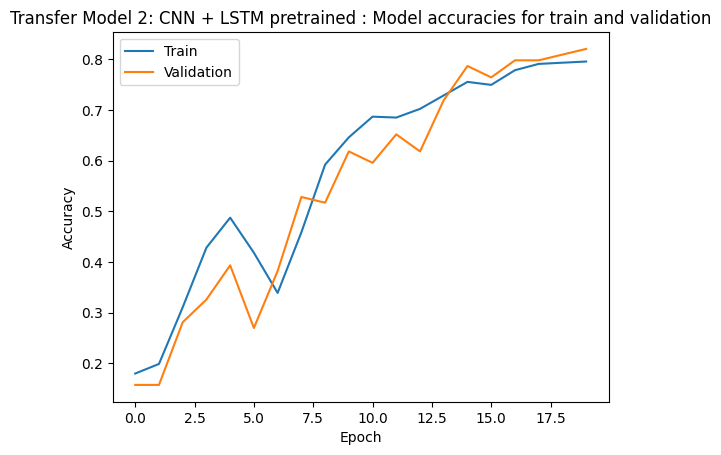

In [ ]:
print(tf_model_2_hist.history.keys())

plt.clf()
plt.plot(tf_model_2_hist.history['accuracy'])
plt.plot(tf_model_2_hist.history['val_accuracy'])
plt.title('Transfer Model 2: CNN + LSTM pretrained : Model accuracies for train and validation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Transfer learning: Model 3 - CNN + LSTM pretrained + Some adjustments

In [ ]:
tf_model_3 = tf.keras.models.load_model('saved_model/model7save')
tf_model_3.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding_6 (Embedding)     (None, None, 16)          1120000   
                                                                 
 conv1d_5 (Conv1D)           (None, None, 80)          25680     
                                                                 
 average_pooling1d_2 (Averag  (None, None, 80)         0         
 ePooling1D)                                                     
                                                                 
 conv1d_6 (Conv1D)           (None, None, 80)          64080     
                                                                 
 average_pooling1d_3 (Averag  (None, None, 80)        

In [ ]:
tf_model_3.layers[0].trainable = True
tf_model_3.layers[1].trainable = True
tf_model_3.layers[2].trainable = False
tf_model_3.layers[3].trainable = False
tf_model_3.layers[4].trainable = False
tf_model_3.layers[5].trainable = False
tf_model_3.layers[6].trainable = False
tf_model_3.layers[7].trainable = False
tf_model_3.layers[8].trainable = False
tf_model_3.layers[9].trainable = False
tf_model_3.layers[10].trainable = False
tf_model_3.layers[11].trainable = False
tf_model_3.layers[12].trainable = False

tf_model_3.layers[13].trainable = True

tf_model_3.add(tf.keras.layers.Dense(5, activation='relu', name='new_dense_6'))
tf_model_3.add(tf.keras.layers.Dense(5, activation='relu', name='new_dense_7'))
tf_model_3.add(tf.keras.layers.Dense(5, activation='softmax', name='new_dense_8'))

In [ ]:
tf_model_3.compile(optimizer='adam',
              loss='categorical_crossentropy',
             metrics=['accuracy'])

tf_model_3_hist = tf_model_3.fit(X_train, y_train_le,
          batch_size=32,
          epochs=20,
         validation_split=0.05)

Epoch 1/20
53/53 [==============================] - 10s 127ms/step - loss: 1.5879 - accuracy: 0.3767 - val_loss: 1.5556 - val_accuracy: 0.4831
Epoch 2/20
53/53 [==============================] - 6s 116ms/step - loss: 1.4891 - accuracy: 0.4494 - val_loss: 1.4349 - val_accuracy: 0.4944
Epoch 3/20
53/53 [==============================] - 6s 105ms/step - loss: 1.3461 - accuracy: 0.4536 - val_loss: 1.3161 - val_accuracy: 0.4944
Epoch 4/20
53/53 [==============================] - 5s 104ms/step - loss: 1.2016 - accuracy: 0.4571 - val_loss: 1.2150 - val_accuracy: 0.5393
Epoch 5/20
53/53 [==============================] - 6s 102ms/step - loss: 1.0701 - accuracy: 0.5937 - val_loss: 1.1221 - val_accuracy: 0.6067
Epoch 6/20
53/53 [==============================] - 6s 108ms/step - loss: 0.9592 - accuracy: 0.6044 - val_loss: 1.0513 - val_accuracy: 0.6067
Epoch 7/20
53/53 [==============================] - 6s 105ms/step - loss: 0.8640 - accuracy: 0.6032 - val_loss: 0.9695 - val_accuracy: 0.6067
Epoch

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


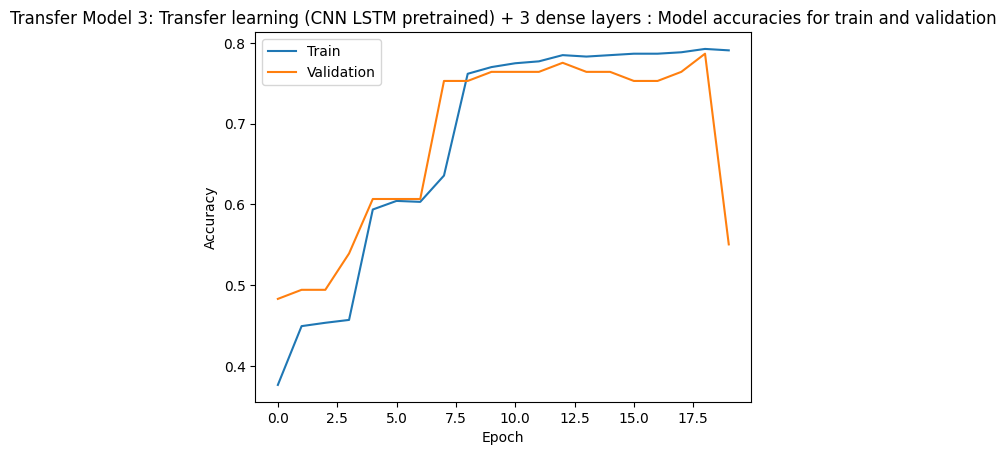

In [ ]:
print(tf_model_3_hist.history.keys())

plt.clf()
plt.plot(tf_model_3_hist.history['accuracy'])
plt.plot(tf_model_3_hist.history['val_accuracy'])
plt.title('Transfer Model 3: Transfer learning (CNN LSTM pretrained) + 3 dense layers : Model accuracies for train and validation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Common requirements to train from scratch models

In [ ]:
maxlen = 400
maxlen = 400
embedding_dims = 16
epochs = 5

max_features = 70000

category_no = 5

vectorizer = tf.keras.layers.TextVectorization(
    standardize="lower_and_strip_punctuation",
    split="whitespace",
    output_mode="int",
)
vectorizer.adapt(X_train.to_numpy())

### Model 4 - From scratch LSTM

In [ ]:
tf_model_4 = Sequential()

tf_model_4.add(vectorizer)

tf_model_4.add(Embedding(max_features, embedding_dims))
tf_model_4.add(TimeDistributed(Dense(400,activation="relu")))
tf_model_4.add(LSTM(embedding_dims, return_sequences=False))
tf_model_4.add(Dense(400,activation="relu"))
tf_model_4.add(Dense(400,activation="sigmoid"))
tf_model_4.add(Dense(400,activation="relu"))
tf_model_4.add(Dense(category_no,activation=tf.keras.activations.softmax))

In [ ]:
tf_model_4.compile(optimizer='adam',
              loss='categorical_crossentropy',
             metrics=['accuracy'])

tf_model_4.summary()

tf_4hist = tf_model_4.fit(X_train, y_train_le,
          batch_size=32,
          epochs=20,
         validation_split=0.10)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, None)             0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, None, 16)          1120000   
                                                                 
 time_distributed (TimeDistr  (None, None, 400)        6800      
 ibuted)                                                         
                                                                 
 lstm (LSTM)                 (None, 16)                26688     
                                                                 
 dense_1 (Dense)             (None, 400)               6800      
                                                                 
 dense_2 (Dense)             (None, 400)               1

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


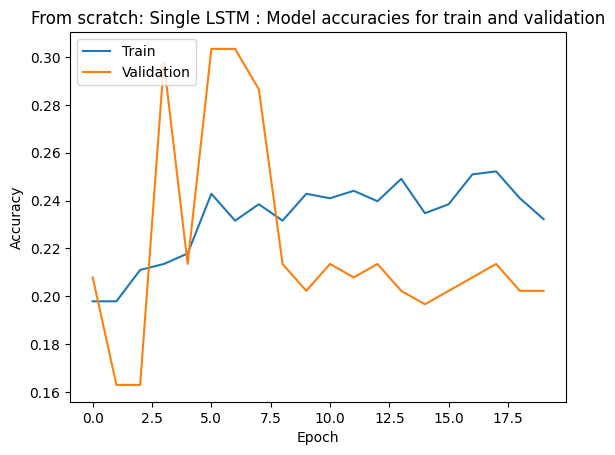

In [ ]:
print(tf_4hist.history.keys())

plt.clf()
plt.plot(tf_4hist.history['accuracy'])
plt.plot(tf_4hist.history['val_accuracy'])
plt.title('From scratch: Single LSTM : Model accuracies for train and validation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### From scratch: Model 5 - Same steps as in Model 3

In [ ]:
tf_model_5 = Sequential()

tf_model_5.add(vectorizer)

tf_model_5.add(Embedding(max_features, embedding_dims))
tf_model_5.add(Conv1D(80, 20, padding='same', activation='relu'))
tf_model_5.add(AveragePooling1D())
tf_model_5.add(Conv1D(80, 10, padding='same', activation='relu'))
tf_model_5.add(AveragePooling1D())
tf_model_5.add(Conv1D(80, 5, padding='same', activation='relu'))
tf_model_5.add(AveragePooling1D())
tf_model_5.add(LSTM(embedding_dims, return_sequences=True))
tf_model_5.add(LSTM(embedding_dims, return_sequences=False))
tf_model_5.add(Dense(400,activation="relu"))
tf_model_5.add(Dense(400,activation="relu"))
tf_model_5.add(Dense(400,activation="relu"))
tf_model_5.add(tf.keras.layers.Dense(5, activation='relu'))
tf_model_5.add(tf.keras.layers.Dense(5, activation='relu'))
tf_model_5.add(Dense(5,activation=tf.keras.activations.softmax))

In [ ]:
tf_model_5.compile(optimizer='adam',
              loss='categorical_crossentropy',
             metrics=['accuracy'])

tf_model_5.summary()

tf_5hist = tf_model_4.fit(X_train, y_train_le,
          batch_size=32,
          epochs=20,
         validation_split=0.10)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, None)             0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, None, 16)          1120000   
                                                                 
 conv1d (Conv1D)             (None, None, 80)          25680     
                                                                 
 average_pooling1d (AverageP  (None, None, 80)         0         
 ooling1D)                                                       
                                                                 
 conv1d_1 (Conv1D)           (None, None, 80)          64080     
                                                                 
 average_pooling1d_1 (Averag  (None, None, 80)        

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


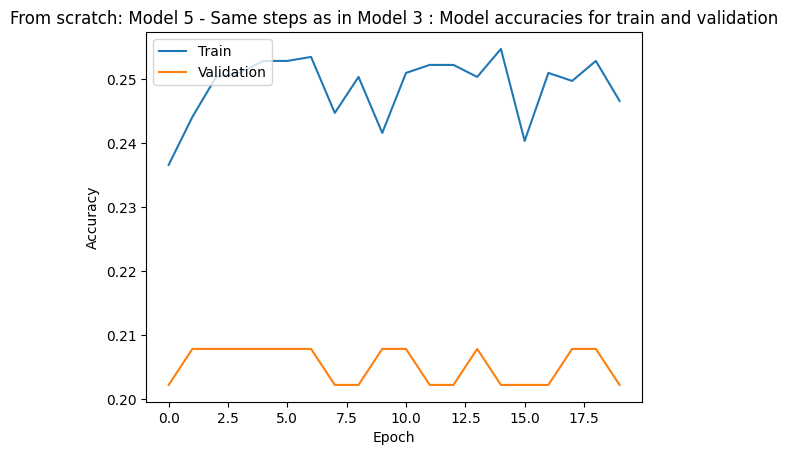

In [ ]:
print(tf_5hist.history.keys())

plt.clf()
plt.plot(tf_5hist.history['accuracy'])
plt.plot(tf_5hist.history['val_accuracy'])
plt.title('From scratch: Model 5 - Same steps as in Model 3 : Model accuracies for train and validation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Evaluating the models using test data

In [ ]:
p2_model_accs = []

In [ ]:
acc1 = tf_model_1.evaluate(X_test, y_test_le, batch_size=32)
print("Model 1: Test loss/ Test acc")
print(acc1)
p2_model_accs.append(acc1[1])

14/14 [==============================] - 0s 10ms/step - loss: 0.5833 - accuracy: 0.8809
Model 1: Test loss/ Test acc
[0.5833443403244019, 0.8808988928794861]


In [ ]:
acc2 = tf_model_2.evaluate(X_test, y_test_le, batch_size=32)
print("Model 2: Test loss/ Test acc")
print(acc2)
p2_model_accs.append(acc2[1])

14/14 [==============================] - 0s 31ms/step - loss: 0.8120 - accuracy: 0.6989
Model 2: Test loss/ Test acc
[0.8119595050811768, 0.6988763809204102]


In [ ]:
acc3 = tf_model_3.evaluate(X_test, y_test_le, batch_size=32)
print("Model 3: Test loss/ Test acc")
print(acc3)
p2_model_accs.append(acc3[1])

14/14 [==============================] - 0s 31ms/step - loss: 0.7862 - accuracy: 0.6562
Model 3: Test loss/ Test acc
[0.7861959934234619, 0.6561797857284546]


In [ ]:
acc4 = tf_model_4.evaluate(X_test, y_test_le, batch_size=32)
print("Model 4: Test loss/ Test acc")
print(acc4)
p2_model_accs.append(acc4[1])

14/14 [==============================] - 3s 216ms/step - loss: 1.6050 - accuracy: 0.2180
Model 4: Test loss/ Test acc
[1.6049730777740479, 0.21797752380371094]


In [ ]:
acc5 = tf_model_5.evaluate(X_test, y_test_le, batch_size=32)
print("Model 5: Test loss/ Test acc")
print(acc5)
p2_model_accs.append(acc5[1])

14/14 [==============================] - 1s 32ms/step - loss: 1.6094 - accuracy: 0.2157
Model 5: Test loss/ Test acc
[1.6094386577606201, 0.21573033928871155]


### Plotting test accuracies as a graph

In [ ]:
model_nos = [1,2,3,4,5]

# Plot as a bar-graph
fig2 = px.bar(
    proc_dataset, x=model_nos, y=p2_model_accs,
    title = "Fig: Evaluation accuracies of Part 2 models",
    labels={'x' : 'Model No.', 'y': 'Test Accuracy'}
)

fig2.update_layout(barmode='stack', xaxis={'categoryorder':'total descending'})

fig2.show()

As seen from the graphs, the testing accuracy for the transfer models is higher than the testing accuracy of the from scratch models. This may be due to various factors like:
1) The dataset is different
2) The pretrained models were run over a larger number of records
3) More words are there in the embeddings
(The above are theories)

### Downloading the test set

In [ ]:
test_data_df2 = pd.DataFrame({
    'bodyContent' : X_test,
    'sectionName' : y_test
})
display(test_data_df2)

,bodyContent,sectionName
920,oscar nominees lack pulling power this year s ...,entertainment
2149,wi-fi web reaches farmers in peru a network of...,tech
1710,stevens named in england line-up england have ...,sport
97,ireland win eclipses refereeing errors the i...,sport
1343,melzer shocks agassi in san jose second seed a...,sport
...,...,...
108,hong kong in 2011 world cup bid hong kong is h...,sport
304,india s rupee hits five-year high india s rupe...,business
2210,teens know little of politics teenagers ques...,politics
2154,green reports shun supply chain nearly 20% mor...,business


In [ ]:
test_data_df2.to_csv("bbc_testrecords.csv")

### Saving the best models

We will be saving Model 1 and Model 5 for the demo notebook

In [ ]:
tf_model_1.save('saved_model/tfmodel1save')

INFO:tensorflow:Assets written to: saved_model/tfmodel1save\assets


INFO:tensorflow:Assets written to: saved_model/tfmodel1save\assets


In [ ]:
tf_model_5.save('saved_model/tfmodel5save')

INFO:tensorflow:Assets written to: saved_model/tfmodel5save\assets


INFO:tensorflow:Assets written to: saved_model/tfmodel5save\assets
